# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, math, time
from pathlib import Path
from datetime import date

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

In [3]:
from IPython.core.debugger import set_trace

# Define a VAE Model
Initially designed for 2D input images.
Based on this paper: https://arxiv.org/abs/1807.01349

In [4]:
depth = 64      # initial depth to convolve channels into
n_channels = 3  # number of channels (RGB)
filt_size = 4   # convolution filter size
stride = 2      # stride for conv
pad = 1         # padding added for conv

class VAE2D(nn.Module):
    def __init__(self, img_size, n_latent=100):
        
        # Model setup
        #############
        super(VAE2D, self).__init__()
        self.n_latent = n_latent
        n = math.log2(img_size)
        assert n == round(n), 'Image size must be a power of 2'  # restrict image input sizes permitted
        assert n >= 3, 'Image size must be at least 8'           # low dimensional data won't work well
        n = int(n)

        # Encoder - first half of VAE
        #############################
        self.encoder = nn.Sequential()  
        # input: n_channels x img_size x img_size
        # ouput: depth x conv_img_size^2
        # conv_img_size = (img_size - filt_size + 2 * pad) / stride + 1
        self.encoder.add_module('input-conv', nn.Conv2d(n_channels, depth, filt_size, stride, pad,
                                                        bias=True))
        self.encoder.add_module('input-relu', nn.ReLU(inplace=True))
        
        # Add conv layer for each power of 2 over 3 (min size)
        # Pyramid strategy with batch normalization added
        for i in range(n - 3):
            # input: depth x conv_img_size^2
            # output: o_depth x conv_img_size^2
            # i_depth = o_depth of previous layer
            i_depth = depth * 2 ** i
            o_depth = depth * 2 ** (i + 1)
            self.encoder.add_module(f'pyramid_{i_depth}-{o_depth}_conv',
                                    nn.Conv2d(i_depth, o_depth, filt_size, stride, pad, bias=True))
            self.encoder.add_module(f'pyramid_{o_depth}_batchnorm',
                                    nn.BatchNorm2d(o_depth))
            self.encoder.add_module(f'pyramid_{o_depth}_relu',
                                    nn.ReLU(inplace=True))
        
        # Latent representation
        #######################
        # Convolve the encoded image into the latent space, once for mu and once for logvar
        max_depth = depth * 2 ** (n - 3)
        self.conv_mu = nn.Conv2d(max_depth, n_latent, filt_size)      # return the mean of the latent space 
        self.conv_logvar = nn.Conv2d(max_depth, n_latent, filt_size)  # return the log variance of the same
        
        
        # Decoder - second half of VAE
        ##############################
        self.decoder = nn.Sequential()
        # input: max_depth x conv_img_size^2 (8 x 8)  TODO double check sizes
        # output: n_latent x conv_img_size^2 (8 x 8)
        # default stride=1, pad=0 for this layer
        self.decoder.add_module('input-conv', nn.ConvTranspose2d(n_latent, max_depth, filt_size, bias=True))
        self.decoder.add_module('input-batchnorm', nn.BatchNorm2d(max_depth))
        self.decoder.add_module('input-relu', nn.ReLU(inplace=True))
    
        # Reverse the convolution pyramids used in the encoder
        for i in range(n - 3, 0, -1):
            i_depth = depth * 2 ** i
            o_depth = depth * 2 ** (i - 1)
            self.decoder.add_module(f'pyramid_{i_depth}-{o_depth}_conv',
                                    nn.ConvTranspose2d(i_depth, o_depth, filt_size, stride, pad, bias=True))
            self.decoder.add_module(f'pyramid_{o_depth}_batchnorm',
                                    nn.BatchNorm2d(o_depth))
            self.decoder.add_module(f'pyramid_{o_depth}_relu', nn.ReLU(inplace=True))
        
        # Final transposed convolution to return to img_size
        # Final activation is tanh instead of relu to allow negative pixel output
        self.decoder.add_module('output-conv', nn.ConvTranspose2d(depth, n_channels,
                                                                  filt_size, stride, pad, bias=True))
        self.decoder.add_module('output-tanh', nn.Tanh())

        # Model weights init
        ####################
        # Randomly initialize the model weights using kaiming method
        # Reference: "Delving deep into rectifiers: Surpassing human-level
        # performance on ImageNet classification" - He, K. et al. (2015)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def encode(self, imgs):
        """
        Encode the images into latent space vectors (mean and log variance representation)
        input:  imgs   [batch_size, 3, img_size, img_size]
        output: mu     [batch_size, n_latent, 1, 1]
                logvar [batch_size, n_latent, 1, 1]
        """
        output = self.encoder(imgs)
        output = output.squeeze(-1).squeeze(-1)
        return [self.conv_mu(output), self.conv_logvar(output)]

    def generate(self, mu, logvar):
        """
        Generates a random latent vector using the trained mean and log variance representation
        input:  mu     [batch_size, n_latent, 1, 1]
                logvar [batch_size, n_latent, 1, 1]
        output: gen    [batch_size, n_latent, 1, 1]
        """
        std = torch.exp(0.5 * logvar)
        gen = torch.randn_like(std)
        return gen.mul(std).add_(mu)

    def decode(self, gen):
        """
        Restores an image representation from the generated latent vector
        input:  gen      [batch_size, n_latent, 1, 1]
        output: gen_imgs [batch_size, 3, img_size, img_size]
        """
        return self.decoder(gen)

    def forward(self, imgs):
        """
        Generates reconstituted images from input images based on learned representation
        input: imgs     [batch_size, 3, img_size, img_size]
        ouput: gen_imgs [batch_size, 3, img_size, img_size]
               mu       [batch_size, n_latent]
               logvar   [batch_size, n_latent]
        """
        mu, logvar = self.encode(imgs)
        gen = self.generate(mu, logvar)
        for tensor in (mu, logvar):
            tensor = tensor.squeeze(-1).squeeze(-1)
        return self.decode(gen), mu, logvar


In [20]:
model = VAE2D(128)

In [21]:
model

VAE2D(
  (encoder): Sequential(
    (input-conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (input-relu): ReLU(inplace)
    (pyramid_64-128_conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (pyramid_128_batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid_128_relu): ReLU(inplace)
    (pyramid_128-256_conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (pyramid_256_batchnorm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid_256_relu): ReLU(inplace)
    (pyramid_256-512_conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (pyramid_512_batchnorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pyramid_512_relu): ReLU(inplace)
    (pyramid_512-1024_conv): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (pyramid_1024_batchno

# Define a loss function
Must be suitable for anomaly detection by recreation similarity

In [22]:
class VAE2DLoss(nn.Module):

    def __init__(self, kl_weight=1):
        super(VAE2DLoss, self).__init__()
        self.kl_weight = kl_weight

    def forward(self, gen_imgs, imgs, mu, logvar):
        """
        input:  gen_imgs [batch_size, n_channels, img_size, img_size]
                imgs     [batch_size, n_channels, img_size, img_size]
                mu       [batch_size, n_latent]
                logvar   [batch_size, n_latent]
        output: loss      scalar (-ELBO)
                loss_desc {'KL': KL, 'gen_logp': gen_err}
        """
        batch_size = imgs.shape[0]
        gen_err = (imgs - gen_imgs).pow(2).reshape(batch_size, -1)
        gen_err = 0.5 * torch.sum(gen_err, dim=-1)
        gen_err = torch.mean(gen_err)

        # KL(q || p) = -log_sigma + sigma^2/2 + mu^2/2 - 1/2
        KL = (-logvar + logvar.exp() + mu.pow(2) - 1) * 0.5
        KL = torch.sum(KL, dim=-1)
        KL = torch.mean(KL)

        loss = gen_err + self.kl_weight * KL
        return loss, {'KL': KL, 'gen_logp': -gen_err}

# Load Data

In [23]:
def load_datasets(img_size, data_path):
    """
    Load the image datasets from vae_train and vae_test
    Transform to correct image size
    """
    
    train_path = data_path / 'train/train/'
    val_path = data_path / 'train/val/'
    test_path = data_path / 'test/'
    
    norm_args = {'mean': [0.5] * n_channels,
                 'std': [0.5] * n_channels}
    jitter_args = {'brightness': 0.1,
                   'contrast': 0.1,
                   'saturation': 0.1}  # hue unchanged
    
    train_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomCrop(img_size),          # vary horizontal position
        transforms.RandomHorizontalFlip(p=0.25),  # vary photo orientation
        transforms.RandomVerticalFlip(p=0.25),
        transforms.ColorJitter(**jitter_args),    # vary photo lighting
        transforms.ToTensor(),
        transforms.Normalize(**norm_args)])
    
    test_transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),  # assume center is most important
        transforms.ToTensor(),
        transforms.Normalize(**norm_args)])

    train_ds = datasets.ImageFolder(train_path, train_transform)
    val_ds = datasets.ImageFolder(val_path, test_transform)
    test_ds = datasets.ImageFolder(test_path, test_transform)
    
    
    loader_args = {'shuffle': True,
                   'num_workers': 4}
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, **loader_args)
    val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, **loader_args)
    test_dl = torch.utils.data.DataLoader(test_ds, batch_size=1, ** loader_args)
    
    return train_dl, val_dl, test_dl

In [24]:
# Model/Data parameters
desc = 'cracks'
data_path = Path('data/cracks/')
img_size = 128
n_channels = 3

# Training parameters
epochs = 40
lr = 1e-4                # learning rate
lr_decay = 0.1           # lr decay factor
kl_weight = 0.01         # weighted factor of the KL term
schedule = [20, 30]      # decrease lr at these epochs
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Checkpoints/Logging parameters
save_path = Path(f"models/{date.today().strftime('%y%m%d')}-{desc}/")
load_path = None         # checkpoint to resume from (default None)
log_freq = 30            # print status after this many batches

In [25]:
train_dl, val_dl, test_dl = load_datasets(img_size, data_path)

In [26]:
print(len(train_dl), len(val_dl), len(test_dl))

188 63 8000


# Build the Model

In [27]:
# Create model
model = VAE2D(img_size)

# Load optimizer and scheduler
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, schedule, lr_decay)

# Load checkpoint if any
if load_path is not None:
    checkpoint = torch.load(load_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    print("Checkpoint loaded")
    print(f"Validation loss: {checkpoint['val_loss']}")
    print(f"Epoch: {checkpoint['epoch']}")

# Set loss criterion
criterion = VAE2DLoss(kl_weight=kl_weight)

# Move to GPU
model = model.to(device)
criterion = criterion.to(device)

# Train the Model

In [28]:
# Make save directory
if save_path.is_dir():
    print(f"Folder {save_path} already exists")
else:
    os.mkdir(save_path)

Folder models/190124-cracks already exists


In [29]:
# TODO - add in logging to Visdom

In [30]:
# Convenience classes
class StopWatch(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.start = time.time()
        self.lap_start = time.time()
        self.elapsed = []
    
    def lap(self):
        self.elapsed.append(time.time() - self.lap_start)
    
class AvgTracker(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.sum = 0
        self.avg = 0
        self.cnt = 0

    def update(self, val):
        self.val = val
        self.sum += val
        self.cnt += 1
        self.avg = self.sum / self.cnt

In [31]:
def trainVAE2D(dl):
    loss_tracker = AvgTracker()
    kl_tracker = AvgTracker()
    logp_tracker = AvgTracker()
    timer = StopWatch()
    
    for i, (X, _) in enumerate(dl):
        
        X = X.to(device)
        timer.lap()  # load time
        
        # Generate images and compute loss
        X_hat, mu, logvar = model(X)
        loss, loss_desc = criterion(X_hat, X, mu, logvar)
        timer.lap()  # gen time
        
        loss_tracker.update(loss.item())
        kl_tracker.update(loss_desc['KL'].item())
        logp_tracker.update(loss_desc['gen_logp'].item())
        
        if model.training:
            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            timer.lap()  # backprop time
        
        if (i + 1) % log_freq == 0:
            # Print progress
            print(f'Epoch: {epoch + 1} ({i + 1}/{len(dl)})')
            print(f'\tData load time: {timer.elapsed[0]:.3f} sec')
            print(f'\tGeneration time: {timer.elapsed[1]:.3f} sec')
            if model.training:
                print(f'\tBackprop time: {timer.elapsed[2]:.3f} sec')
            print(f'\tLog probability: {logp_tracker.val:.4f} '
                  f'(avg {logp_tracker.avg:.4f})')
            print(f'\tKL: {kl_tracker.val:.4f} (avg {kl_tracker.avg:.4f})')
            print(f'\tLoss: {loss_tracker.val:.4f} (avg {loss_tracker.avg:.4f})')

    return loss_tracker.avg, kl_tracker.avg, logp_tracker.avg


def testVAE2D(test_dl):
    abnormal_loss_tracker = AvgTracker()
    normal_loss_tracker = AvgTracker()

    model.eval()
    for i, (X, y) in tqdm(enumerate(test_dl)):

        X = X.to(device)
        X_hat, mu, logvar = model(X)
        loss, loss_desc = criterion(X_hat, X, mu, logvar)

        # Normal
        if target.item() == 1:
           normal_loss_tracker.update(loss.item())
        # Abnormal
        else:
           abnormal_loss_tracker.update(loss.item())

    return normal_loss_tracker.avg, abnormal_loss_tracker.avg


In [32]:
# Main loop
best_loss = np.inf
for epoch in range(epochs):

    model.train()
    scheduler.step()
    train_loss, train_kl, train_logp = trainVAE2D(train_dl)
    
    model.eval()
    with torch.no_grad():
        val_loss, val_kl, val_logp = trainVAE2D(val_dl)

    # Report training progress to user
    if val_loss < best_loss:
        print('Saving checkpoint..')
        best_loss = val_loss
        save_dict = {'epoch': epoch + 1,
                     'state_dict': model.state_dict(),
                     'val_loss': val_loss,
                     'optimizer': optimizer.state_dict()}
        path = save_path / 'best_model.pth.tar'
        torch.save(save_dict, path)
    print(f'Lowest validation loss: {best_loss:.4f}')
    

Epoch: 1 (50/188)
	Data load time: 0.433 sec
	Generation time: 0.446 sec
	Backprop time: 0.688 sec
	Log probability: -804.7445 (avg -2245.3889)
	KL: 590.0062 (avg 577420149.6742)
	Loss: 810.6446 (avg 5776446.3595)
Epoch: 1 (100/188)
	Data load time: 0.433 sec
	Generation time: 0.446 sec
	Backprop time: 0.688 sec
	Log probability: -430.1086 (avg -1440.2734)
	KL: 69.3402 (avg 288711510.5761)
	Loss: 430.8020 (avg 2888555.1161)
Epoch: 1 (150/188)
	Data load time: 0.433 sec
	Generation time: 0.446 sec
	Backprop time: 0.688 sec
	Log probability: -294.3524 (avg -1098.3467)
	KL: 108.5148 (avg 192474478.6502)
	Loss: 295.4375 (avg 1925842.9578)
Epoch: 1 (50/63)
	Data load time: 0.346 sec
	Generation time: 0.357 sec
	Log probability: -207.3204 (avg -251.3736)
	KL: 16.9356 (avg 120252.0671)
	Loss: 207.4898 (avg 1453.8942)
Saving checkpoint..
Lowest validation loss: 1208.0398
Epoch: 2 (50/188)
	Data load time: 0.439 sec
	Generation time: 0.446 sec
	Backprop time: 0.683 sec
	Log probability: -233.09

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/e

KeyboardInterrupt: 

  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


### ADD VISUALIZATIONS

In [ ]:
import matplotlib.pyplot as plt

In [123]:
# TODO include in epoch loop?
# TODO look into what the scheduler is for
# visualize reconst and free sample

with torch.no_grad():

    val_iter = iter(val_dl)

    # Generate an image from validation set
    imgs = val_iter._get_batch()[1][0][:25]
    imgs = imgs.to(device)
    gen_imgs, mu, logvar = model(imgs)
    loss, loss_desc = criterion(gen_imgs, imgs, mu, logvar)
    print(*(val.item() for val in (loss, loss_desc['KL'], loss_desc['gen_logp'])))
    
    # Scale images back to 0-1
    imgs = (imgs + 1) / 2
    grid = make_grid(imgs, nrow=5, padding=20)
    gen_imgs = (gen_imgs + 1) / 2
    gen_grid = make_grid(gen_imgs, nrow=5, padding=20)
    
    grid = grid.cpu()
    gen_grid = gen_grid.cpu()

109.13057708740234 17.520858764648438 -108.95536804199219


Input Images


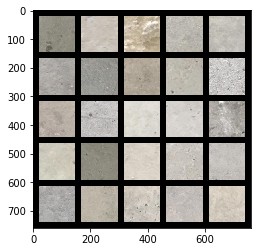

In [124]:
plt.imshow(grid.permute(1, 2, 0))
print('Input Images')

Generated Images


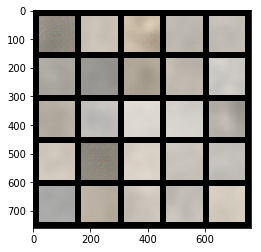

In [125]:
plt.imshow(gen_grid.permute(1, 2, 0))
print('Generated Images')

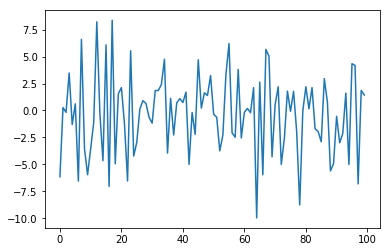

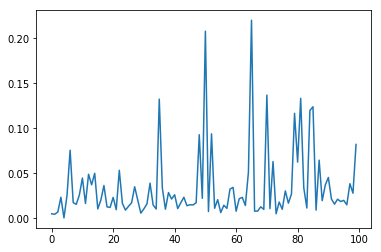

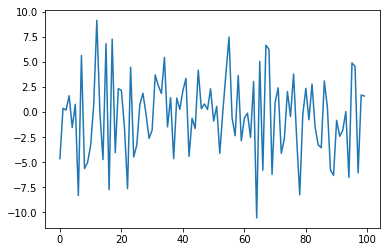

In [126]:
mu = mu.cpu()
std = (0.5 * logvar).exp().cpu()

num = 1
for i in np.random.choice(range(mu.shape[0]), num):
    plt.figure()
    mu_eg = mu[i, :].squeeze(-1).squeeze(-1)
    plt.plot(mu_eg.numpy())
    plt.figure()
    std_eg = std[i, :].squeeze(-1).squeeze(-1)
    plt.plot(std_eg.numpy())
    plt.figure()
    gen_eg = model.generate(mu[i, :], std[i, :]).squeeze(-1).squeeze(-1)
    plt.plot(gen_eg.numpy())

In [104]:
pos_img

tensor([[[[0.4510, 0.4275, 0.4196,  ..., 0.4353, 0.4588, 0.4588],
          [0.4353, 0.4353, 0.4431,  ..., 0.4275, 0.4510, 0.4588],
          [0.4039, 0.4118, 0.4196,  ..., 0.4196, 0.4510, 0.4588],
          ...,
          [0.3569, 0.3725, 0.3647,  ..., 0.4196, 0.4196, 0.4039],
          [0.3647, 0.3725, 0.3961,  ..., 0.3961, 0.3882, 0.3882],
          [0.3569, 0.3647, 0.3961,  ..., 0.3804, 0.3725, 0.3804]],

         [[0.3725, 0.3490, 0.3412,  ..., 0.3412, 0.3647, 0.3647],
          [0.3569, 0.3569, 0.3647,  ..., 0.3333, 0.3569, 0.3647],
          [0.3255, 0.3333, 0.3412,  ..., 0.3255, 0.3569, 0.3647],
          ...,
          [0.2941, 0.3098, 0.3020,  ..., 0.3255, 0.3333, 0.3255],
          [0.3020, 0.3098, 0.3333,  ..., 0.3098, 0.3020, 0.3098],
          [0.2941, 0.3020, 0.3333,  ..., 0.3020, 0.2941, 0.3020]],

         [[0.2784, 0.2549, 0.2471,  ..., 0.2471, 0.2706, 0.2706],
          [0.2627, 0.2627, 0.2706,  ..., 0.2392, 0.2627, 0.2706],
          [0.2314, 0.2392, 0.2471,  ..., 0

In [127]:
with torch.no_grad():

    # Generate an image
    pos_img = pos_img.to(device)
    gen_pos_img, mu, logvar = model(pos_img)
    loss, loss_desc = criterion(gen_imgs, imgs, mu, logvar)
    print(*(val.item() for val in (loss, loss_desc['KL'], loss_desc['gen_logp'])))
    
    # Scale images back to 0-1
    pos_img = (pos_img + 1) / 2
    grid = make_grid(pos_img, nrow=5, padding=20)
    gen_pos_img = (gen_pos_img + 1) / 2
    gen_grid = make_grid(gen_pos_img, nrow=5, padding=20)
    
    grid = grid.cpu()
    gen_grid = gen_grid.cpu()

27.530393600463867 29.155174255371094 -27.238842010498047


Input Images


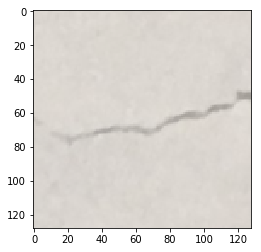

In [114]:
plt.imshow(grid.permute(1, 2, 0))
print('Input Images')

Generated Images


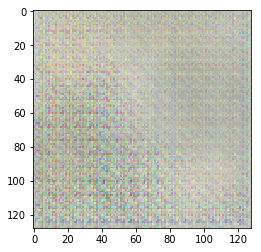

In [115]:
plt.imshow(gen_grid.permute(1, 2, 0))
print('Generated Images')

In [79]:
# Repeat for test images
with torch.no_grad():

    val_iter = iter(test_dl)

    # Generate an image
    imgs = val_iter._get_batch()
    target = imgs[1][1].item()
    imgs = imgs[1][0]
    imgs = imgs.to(device)
    gen_imgs, mu, logvar = model(imgs)
    
    # Scale images back to 0-1
    imgs = (imgs + 1) / 2
    grid = make_grid(imgs, nrow=5, padding=20)
    gen_imgs = (gen_imgs + 1) / 2
    gen_grid = make_grid(gen_imgs, nrow=5, padding=20)
    
    grid = grid.cpu()
    gen_grid = gen_grid.cpu()

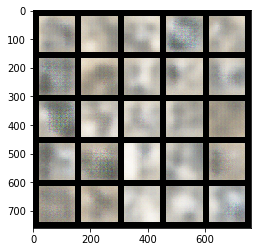

In [83]:
with torch.no_grad():
    # Generate some random images
    noises = torch.randn(25, model.n_latent, 1, 1)
    noises = noises.to(device)
    samples = model.decode(noises)
    
    samples = (samples + 1) / 2
    sample_grid = make_grid(samples, nrow=5, padding=20).cpu()
    
    plt.imshow(sample_grid.permute(1, 2, 0))  # easy way to swapaxes

# Test the Model

In [ ]:
"""
The script for doing outlier detection using different score
"""
import argparse
from model import VAE
from loss import VAELoss
from dataloader import load_vae_test_datasets, load_vae_train_datasets
import os
import torch
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from itertools import product
import numpy as np
import pandas as pd
import scipy.stats as stats

parser = argparse.ArgumentParser()
parser.add_argument('--model_path', required=True, type=str)
parser.add_argument('--data', required=True, type=str)
parser.add_argument('--image_size', default=256, type=int)
parser.add_argument('--cuda', action='store_true')
parser.add_argument('--kl_weight', type=float, default=1,
                    help="weight on KL term")
parser.add_argument('--out_csv', default='result.csv')
args = parser.parse_args()

# load checkpoint
if not os.path.isfile(args.model_path):
    print('%s is not path to a file' % args.model_path)
    exit()
checkpoint = torch.load(args.model_path, map_location=lambda storage, loc: storage)
print("checkpoint loaded!")
print("val loss: {}\tepoch: {}\t".format(checkpoint['val_loss'], checkpoint['epoch']))

# model and criterion
model = VAE(args.image_size)
model.load_state_dict(checkpoint['state_dict'])
criterion = VAELoss(size_average=True, kl_weight=args.kl_weight)

if args.cuda:
    model = model.cuda()
    criterion = criterion.cuda()

# load data
test_loader = load_vae_test_datasets(args.image_size, args.data)

############################# ANOMALY SCORE DEF ##########################
def get_vae_score(vae, image, L=5):
    """
    The vae score for a single image, which is basically the loss
    :param image: [1, 3, 256, 256]
    :return (vae loss, KL, reconst_err)
    """
    image_batch = image.expand(L,
                               image.size(1),
                               image.size(2),
                               image.size(3))
    reconst_batch, mu, logvar = vae.forward(image_batch)
    vae_loss, loss_details = criterion(reconst_batch, image_batch, mu, logvar)
    return vae_loss, loss_details['KL'], -loss_details['reconst_logp']

def _log_mean_exp(x, dim):
    """
    A numerical stable version of log(mean(exp(x)))
    :param x: The input
    :param dim: The dimension along which to take mean with
    """
    # m [dim1, 1]
    m, _ = torch.max(x, dim=dim, keepdim=True)

    # x0 [dm1, dim2]
    x0 = x - m

    # m [dim1]
    m = m.squeeze(dim)

    return m + torch.log(torch.mean(torch.exp(x0),
                                    dim=dim))

def get_iwae_score(vae, image, L=5):
    """
    The vae score for a single image, which is basically the loss
    :param image: [1, 3, 256, 256]
    :return scocre: (iwae score, iwae KL, iwae reconst).
    """
    # [L, 3, 256, 256]
    image_batch = image.expand(L,
                               image.size(1),
                               image.size(2),
                               image.size(3))

    # [L, z_dim, 1, 1]
    mu, logvar = vae.encode(image_batch)
    eps = torch.randn_like(mu)
    z = mu + eps * torch.exp(0.5 * logvar)
    kl_weight = criterion.kl_weight
    # [L, 3, 256, 256]
    reconst = vae.decode(z)
    # [L]
    log_p_x_z = -torch.sum((reconst - image_batch).pow(2).reshape(L, -1),
                          dim=1)

    # [L]
    log_p_z = -torch.sum(z.pow(2).reshape(L, -1), dim=1)

    # [L]
    log_q_z = -torch.sum(eps.pow(2).reshape(L, -1), dim=1)

    iwae_score = -_log_mean_exp(log_p_x_z + (log_p_z - log_q_z)*kl_weight, dim=0)
    iwae_KL_score = -_log_mean_exp(log_p_z - log_q_z, dim=0)
    iwae_reconst_score = -_log_mean_exp(log_p_x_z, dim=0)

    return iwae_score, iwae_KL_score, iwae_reconst_score

############################# END OF ANOMALY SCORE ###########################

# Define the number of samples of each score
def compute_all_scores(vae, image):
    """
    Given an image compute all anomaly score
    return (reconst_score, vae_score, iwae_score)
    """
    vae_loss, KL, reconst_err = get_vae_score(vae, image=image, L=15)
    iwae_loss, iwae_KL, iwae_reconst = get_iwae_score(vae, image, L=15)
    result = {'reconst_score': reconst_err.item(),
              'KL_score': KL.item(),
              'vae_score': vae_loss.item(),
              'iwae_score': iwae_loss.item(),
              'iwae_KL_score': iwae_KL.item(),
              'iwae_reconst_score': iwae_reconst.item()}
    return result


# MAIN LOOP
score_names = ['reconst_score', 'KL_score', 'vae_score',
               'iwae_reconst_score', 'iwae_KL_score', 'iwae_score']
classes = test_loader.dataset.classes
scores = {(score_name, cls): [] for (score_name, cls) in product(score_names,
                                                                 classes)}
model.eval()
with torch.no_grad():
    for idx, (image, target) in tqdm(enumerate(test_loader)):
        cls = classes[target.item()]
        if args.cuda:
            image = image.cuda()

        score = compute_all_scores(vae=model, image=image)
        for name in score_names:
            scores[(name, cls)].append(score[name])

# display the mean of scores
means = np.zeros([len(score_names), len(classes)])
for (name, cls) in product(score_names, classes):
    means[score_names.index(name), classes.index(cls)] = sum(scores[(name, cls)]) / len(scores[(name, cls)])
df_mean = pd.DataFrame(means, index=score_names, columns=classes)
print("###################### MEANS #####################")
print(df_mean)


classes.remove('NV')
auc_result = np.zeros([len(score_names), len(classes) + 1])
# get auc roc for each class
for (name, cls) in product(score_names, classes):
    normal_scores = scores[(name, 'NV')]
    abnormal_scores = scores[(name, cls)]
    y_true = [0]*len(normal_scores) + [1]*len(abnormal_scores)
    y_score = normal_scores + abnormal_scores
    auc_result[score_names.index(name), classes.index(cls)] = roc_auc_score(y_true, y_score)

# add auc roc against all diseases
for name in score_names:
    normal_scores = scores[(name, 'NV')]
    abnormal_scores = np.concatenate([scores[(name, cls)]for cls in classes]).tolist()
    y_true = [0]*len(normal_scores) + [1]*len(abnormal_scores)
    y_score = normal_scores + abnormal_scores
    auc_result[score_names.index(name), -1] = roc_auc_score(y_true, y_score)

df = pd.DataFrame(auc_result, index=score_names, columns=classes + ['ALL'])
# display
print("###################### AUC ROC #####################")
print(df)
print("####################################################")
df.to_csv(args.out_csv)

# fit a gamma distribution
_, val_loader = load_vae_train_datasets(args.image_size, args.data, 32)
model.eval()
all_reconst_err = []
num_val = len(val_loader.dataset)
with torch.no_grad():
    for img, _ in tqdm(val_loader):
        if args.cuda:
            img = img.cuda()

        # compute output
        recon_batch, mu, logvar = model(img)
        loss, loss_details = criterion.forward_without_reduce(recon_batch, img, mu, logvar)
        reconst_err = -loss_details['reconst_logp']
        all_reconst_err += reconst_err.tolist()

fit_alpha, fit_loc, fit_beta=stats.gamma.fit(all_reconst_err)

# using gamma for outlier detection
# get auc roc for each class
LARGE_NUMBER = 1e30

def get_gamma_score(scores):
    result = -stats.gamma.logpdf(scores, fit_alpha, fit_loc, fit_beta)
    # replace inf in result with largest number
    result[result == np.inf] = LARGE_NUMBER
    return result

auc_gamma_result = np.zeros([1, len(classes)+1])
name = 'reconst_score'
for cls in classes:
    normal_scores = get_gamma_score(scores[(name, 'NV')]).tolist()
    abnormal_scores = get_gamma_score(scores[(name, cls)]).tolist()
    y_true = [0]*len(normal_scores) + [1]*len(abnormal_scores)
    y_score = normal_scores + abnormal_scores
    auc_gamma_result[0, classes.index(cls)] = roc_auc_score(y_true, y_score)

# for all class
normal_scores = get_gamma_score(scores[(name, 'NV')]).tolist()
abnormal_scores = np.concatenate([get_gamma_score(scores[(name, cls)]) for cls in classes]).tolist()
y_true = [0]*len(normal_scores) + [1]*len(abnormal_scores)
y_score = normal_scores + abnormal_scores
auc_gamma_result[0, -1] = roc_auc_score(y_true, y_score)
df = pd.DataFrame(auc_gamma_result, index=['gamma score'], columns=classes + ['ALL'])

# display
print("###################### AUC ROC GAMMA #####################")
print(df)
print("##########################################################")
